# Import Library

In [1]:
pip install --upgrade tensorflow keras

   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/615.3 MB 77.3 MB/s eta 0:00:08
ERROR: Operation cancelled by user


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import shutil
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
import keras

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input

# EDA

#### Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/train'

test_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/test'

val_dir = '/content/drive/MyDrive/Dataset_Capstone/faceshape_grey/validation'

In [6]:
# Buat folder jika belum ada
os.makedirs(val_dir, exist_ok=True)

In [7]:
import random
from collections import Counter

# Split ratio (misalnya 50% untuk validation, 50% untuk test)
val_ratio = 0.5

for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    val_split_index = int(len(images) * val_ratio)

    # Pindahkan file ke folder validation
    for image in images[:val_split_index]:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

    # Pindahkan file ke folder test baru
    for image in images[val_split_index:]:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

In [9]:
def check_distribution(dir_path):
    class_counts = Counter()
    for class_name in os.listdir(dir_path):
        class_dir = os.path.join(dir_path, class_name)
        class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

print("Distribusi data di folder train:", check_distribution(train_dir))
print("Distribusi data di folder validation:", check_distribution(val_dir))
print("Distribusi data di folder test baru:", check_distribution(test_dir))

Distribusi data di folder train: Counter({'Square': 799, 'Heart': 798, 'Oblong': 798, 'Oval': 797, 'Round': 789})
Distribusi data di folder validation: Counter({'Heart': 100, 'Oblong': 100, 'Square': 100, 'Round': 99, 'Oval': 99})
Distribusi data di folder test baru: Counter({'Round': 100, 'Heart': 100, 'Oval': 100, 'Oblong': 100, 'Square': 100})


In [11]:
class_names = ['Oblong', 'Heart', 'Round', 'Square', 'Oval']

In [13]:
def create_datasets():
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=True
    )

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        seed=0,
        batch_size=32,
        label_mode='categorical',
        image_size=(224, 224),
        shuffle=False
    )

    return train_ds, validation_ds, test_ds

In [14]:
# Create datasets with or without data augmentation
train_ds, validation_ds, test_ds = create_datasets()

Found 3981 files belonging to 5 classes.
Found 498 files belonging to 5 classes.
Found 500 files belonging to 5 classes.


In [37]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (224, 224, 3)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

# tuning_layer_name = 'block_15_expand'
# tuning_layer = base_model.get_layer(tuning_layer_name)
# tuning_index = base_model.layers.index(tuning_layer)

# # Membekukan semua layer sebelum tuning_layer
# for layer in base_model.layers[:tuning_index]:
#     layer.trainable = False

# Membekukan lapisan dasar
for layer in base_model.layers:
    layer.trainable = False

# base_model = VGG16(input_shape=IMG_SHAPE,
#                    include_top=False,
#                    weights='imagenet')

# for layer in base_model.layers:
#   layer.trainable = False

# Layer augmentasi
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2),
    RandomContrast(0.3),
    RandomTranslation(0.1, 0.1),
], name='data_augmentation')

In [38]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    # Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
learning_rate = 0.0001

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy']>0.80:
            self.model.stop_training = True
            print("\nReached 80% validation accuracy so cancelling training!")

early_stopping_callback = EarlyStoppingCallback()

In [ ]:
EPOCH = 70

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    callbacks=[early_stopping_callback]
)

Epoch 1/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 141ms/step - accuracy: 0.2313 - loss: 1.6954 - val_accuracy: 0.2892 - val_loss: 1.5406
Epoch 2/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - accuracy: 0.2959 - loss: 1.5562 - val_accuracy: 0.3574 - val_loss: 1.4928
Epoch 3/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.3362 - loss: 1.5134 - val_accuracy: 0.3554 - val_loss: 1.4693
Epoch 4/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.3490 - loss: 1.4835 - val_accuracy: 0.4016 - val_loss: 1.4343
Epoch 5/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.3729 - loss: 1.4605 - val_accuracy: 0.4217 - val_loss: 1.4226
Epoch 6/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.3704 - loss: 1.4443 - val_accuracy: 0.4177 - val_loss: 1.4122
Epoch 7/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.3845 - loss: 1.4229 - val_accuracy: 0.4337 - val_loss: 1.3843
Epoch 8/70
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.4023 - loss: 1

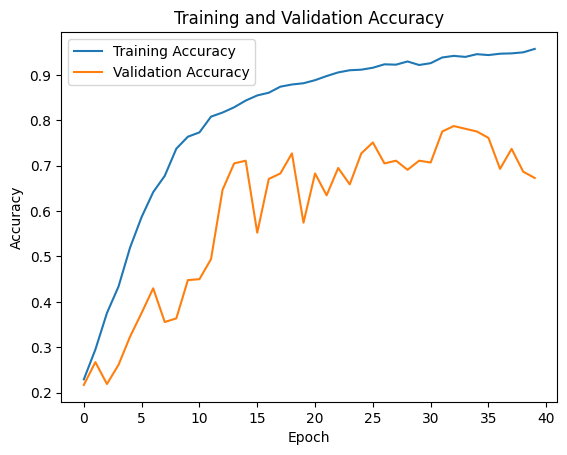

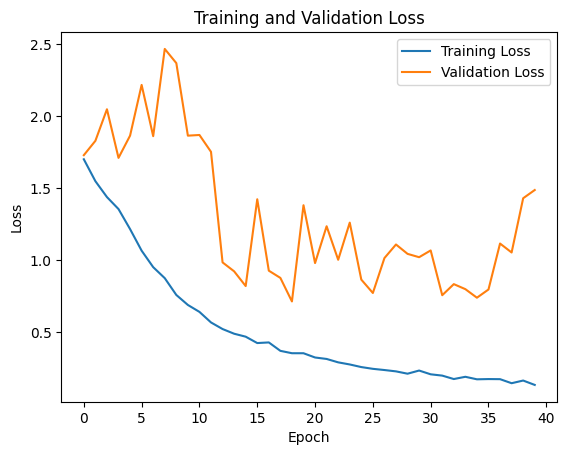

In [19]:
# Visualisasi akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [21]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# test_dir2 = '/content/drive/MyDrive/Dataset_Capstone/extracted_faces/test'

# test_ds

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# You can print the metrics:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
Accuracy: 0.662
Precision: 0.7557820859155676
Recall: 0.662
F1 Score: 0.6508440809813754


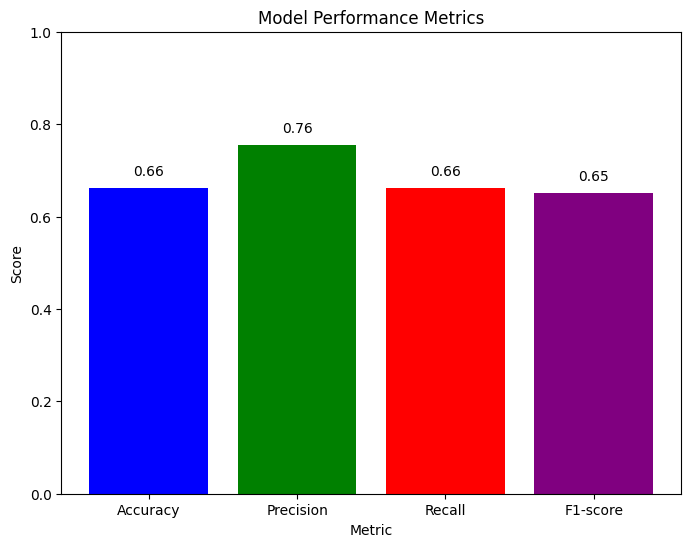

In [22]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

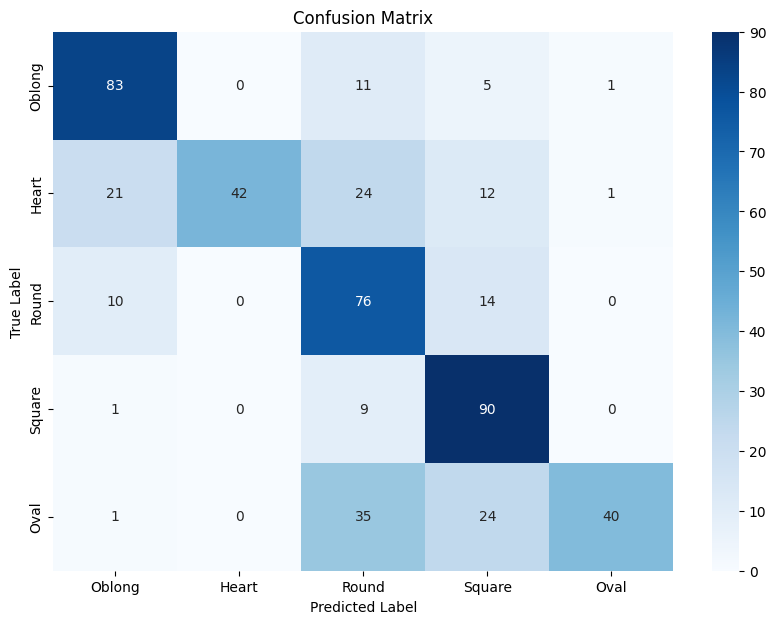

In [23]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
model.save('/content/drive/MyDrive/Model/Model_V6.h5')

In [ ]:
model_path = '/content/drive/MyDrive/Model_V3.keras'
tf.keras.models.save_model(
    model, filepath=model_path, overwrite=True, include_optimizer=True, save_format=None)

## Convert to tfLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/content/drive/MyDrive/Model/Model_V6.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
EPOCH = 70
BATCH_SIZE = 32

history = model.fit(
    train_ds,
    epochs=EPOCH,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

In [ ]:
history_1 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.6526 - loss: 0.9096 - val_accuracy: 0.4891 - val_loss: 1.3397
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - accuracy: 0.6610 - loss: 0.9055 - val_accuracy: 0.5089 - val_loss: 1.2088
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.6588 - loss: 0.9032 - val_accuracy: 0.5327 - val_loss: 1.1937
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.6697 - loss: 0.8828 - val_accuracy: 0.5228 - val_loss: 1.2344
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.6547 - loss: 0.9112 - val_accuracy: 0.4871 - val_loss: 1.2840
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.6747 - loss: 0.8713 - val_accuracy: 0.4891 - val_loss: 1.3445
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.6530 - loss: 0.8907 - val_accuracy: 0.5069 - val_loss: 1.2481
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6749 - loss: 0

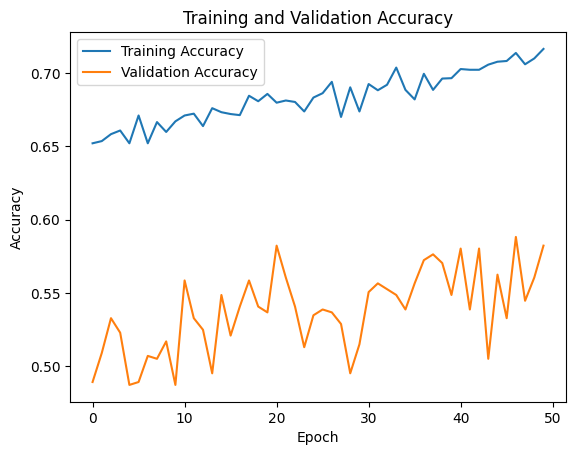

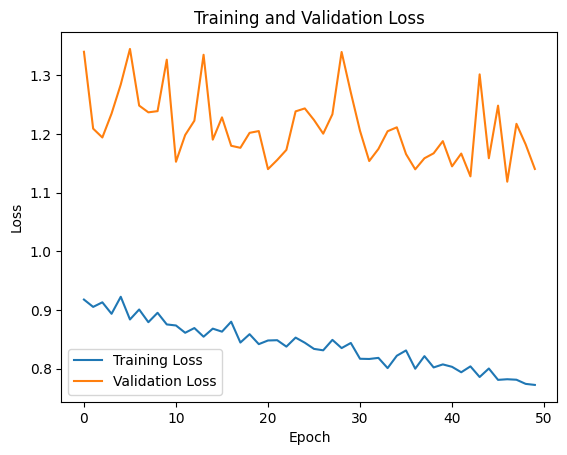

In [ ]:
# Visualisasi akurasi
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Visualisasi loss
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Dapatkan prediksi untuk data testing
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Dapatkan label sebenarnya untuk data testing
y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Hitung dan print metrik
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step


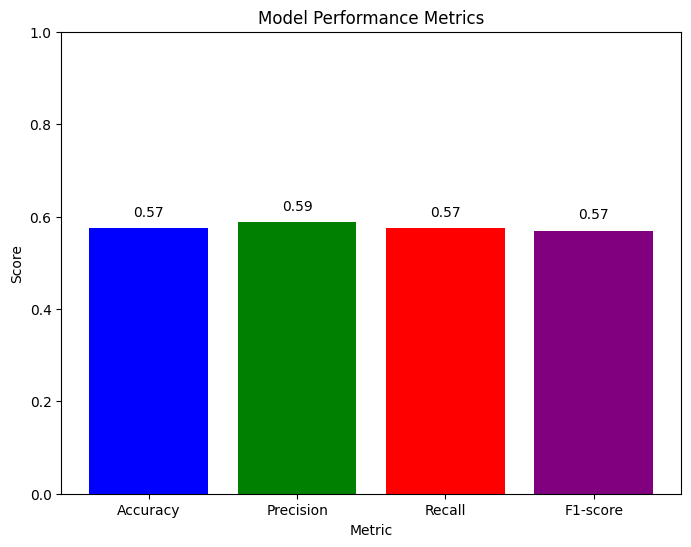

In [ ]:
# Data metrik
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.title('Model Performance Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Mengatur batas sumbu y antara 0 dan 1

# Menambahkan label nilai di atas setiap bar
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

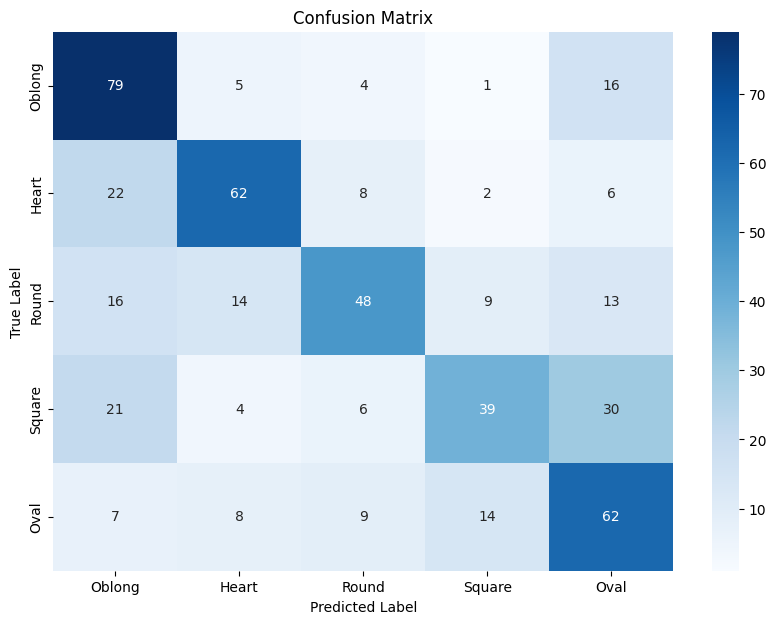

In [ ]:
# Buat dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
history_2 = model.fit(
    train_ds,
    epochs=50,
    verbose=1,
    validation_data=validation_ds,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_callback]
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7212 - loss: 0.7415 - val_accuracy: 0.5644 - val_loss: 1.1940
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step - accuracy: 0.7184 - loss: 0.7686 - val_accuracy: 0.5426 - val_loss: 1.2729
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.7222 - loss: 0.7556 - val_accuracy: 0.5327 - val_loss: 1.2352
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 45s 203ms/step - accuracy: 0.7195 - loss: 0.7643 - val_accuracy: 0.5881 - val_loss: 1.1622
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 173ms/step - accuracy: 0.7082 - loss: 0.7693 - val_accuracy: 0.5327 - val_loss: 1.2335
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.7138 - loss: 0.7547 - val_accuracy: 0.5683 - val_loss: 1.2028
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 173ms/step - accuracy: 0.7196 - loss: 0.7411 - val_accuracy: 0.5624 - val_loss: 1.1988
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.7184 - loss: 0